This notebook comprises scripts to examine GLAB-VOD dataset and create the Figures used in the paper.

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4
import datetime
import os

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from datetime import datetime, timedelta

%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde


In [2]:
path_to_files = '/some_data/'


In [3]:
# create a custom colormap 


import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('jet_r')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)


In [4]:
# plotting function 

def plot_one_map(df, param, vmin, vmax, cmap, sr, title, bar_title, no_left_labels, text, er, no_bottom_labels = False):
   
    ax.set_extent([-180, 180, -56, 80], crs=ccrs.PlateCarree())
    ax.coastlines(alpha = 0.6)
    gls = ax.gridlines(draw_labels=True, alpha = 0.3)
    gls.top_labels=False   # suppress top labels
    gls.right_labels=False # suppress right labels 
    gls.xlabel_style = {'size' :12}
    gls.ylabel_style = {'size' :12}
    if no_left_labels:
        gls.left_labels=False 
    if no_bottom_labels:
        gls.bottom_labels=False 
    sm = plt.scatter(x = df['lon'], y = df ['lat'], c=df [param], s=1,  vmin=vmin, vmax=vmax, cmap=cmap, edgecolors=None, linewidth=0)

    cb = plt.colorbar(sm, shrink=sr)
    cb.ax.tick_params(labelsize=13)
    if bar_title:
        cb.ax.set_title('K', fontsize=13)
    if text:
        plt.text(-80, -40,  er,
         horizontalalignment='right', 
         transform=ccrs.Geodetic(), fontsize=14)

    plt.title(title, fontsize=16)

In [5]:
# read data 
smos_out = pd.read_pickle(path_to_files + 'nn_out_TB_as_smos.pkl')
smos_out_only = smos_out[['time', 'lat', 'lon', 'nn_out_H_res', 'nn_out_H_full' ]]
smos_out_only.columns = ['time', 'lat', 'lon', 'out_resid_H-cs', 'nn_out_H-cs' ]
full_H = pd.read_pickle(path_to_files +'TB_H_out_from_TB_with_TL_2002_target_scaling_rob.pkl')

smos_out = pd.read_pickle(path_to_files + 'nn_out_TB_as_smos.pkl')
smos_out_only = smos_out[['time', 'lat', 'lon', 'nn_out_V_res', 'nn_out_V_full']]
smos_out_only.columns = ['time', 'lat', 'lon', 'out_resid_V-cs', 'nn_out_V-cs' ]
full_V = pd.read_pickle(path_to_files +'TB_V_out_from_TB_with_TL_2002_target_scaling_rob.pkl')

all_vod_t  = xr.open_dataset(path_to_files + 'all_vod_2021.nc') # GLAB VOD
all_vod_t = all_vod_t.to_dataframe().reset_index().dropna()


vod_smap = pd.read_pickle(path_to_files +'vod_raw18.pkl') # SMAP-IB VOD
vod_smap = vod_smap[['time', 'lat', 'lon', 'Optical_Thickness_Nad']]

In [86]:
# put the data together for easier plotting

smos_all_out = pd.concat([full_V, smos_out_only], axis = 0 )
smos_all_out = pd.concat([full_H, smos_out_only], axis = 0 )


In [9]:
# average the data spatially 

smos_map_h = smos_all_out.groupby(['lat', 'lon'])[['nn_out_H-cs']].mean().reset_index()
smos_map = smos_all_out.groupby(['lat', 'lon'])[['nn_out_V-cs']].mean().reset_index()

out_vod_map = all_vod_t.groupby(['lat', 'lon'])[['str_mean']].mean().reset_index()


In [79]:
# difference between SMOS TB and NN_output TB (GLAB-TB)

smos_out['dif_H'] = smos_out['BT_H_IC_Fitted'] - smos_out['nn_out_H_full']
smos_cut_h = smos_out[['time', 'lat', 'lon', 'dif_H']]
smos_cut_h = smos_cut_h.groupby(['lat', 'lon'])[['dif_H']].mean().reset_index()

smos_out['dif_V'] = smos_out['BT_V_IC_Fitted'] - smos_out['nn_out_V_full']
smos_cut = smos_out[['time', 'lat', 'lon', 'dif_V']]
smos_cut = smos_cut.groupby(['lat', 'lon'])[['dif_V']].mean().reset_index()

In [8]:
# GLAB-VOD and SMAP-IB VOD put together

combined = all_vod_t.merge(vod_smap, on = ['lat', 'lon', 'time'], how = 'outer') 
combined = combined.dropna()

comb_vod = combined.groupby(['lat', 'lon'])[['Optical_Thickness_Nad', 'str_mean']].mean().reset_index()

comb_vod['dif'] = comb_vod['Optical_Thickness_Nad']-comb_vod['str_mean']

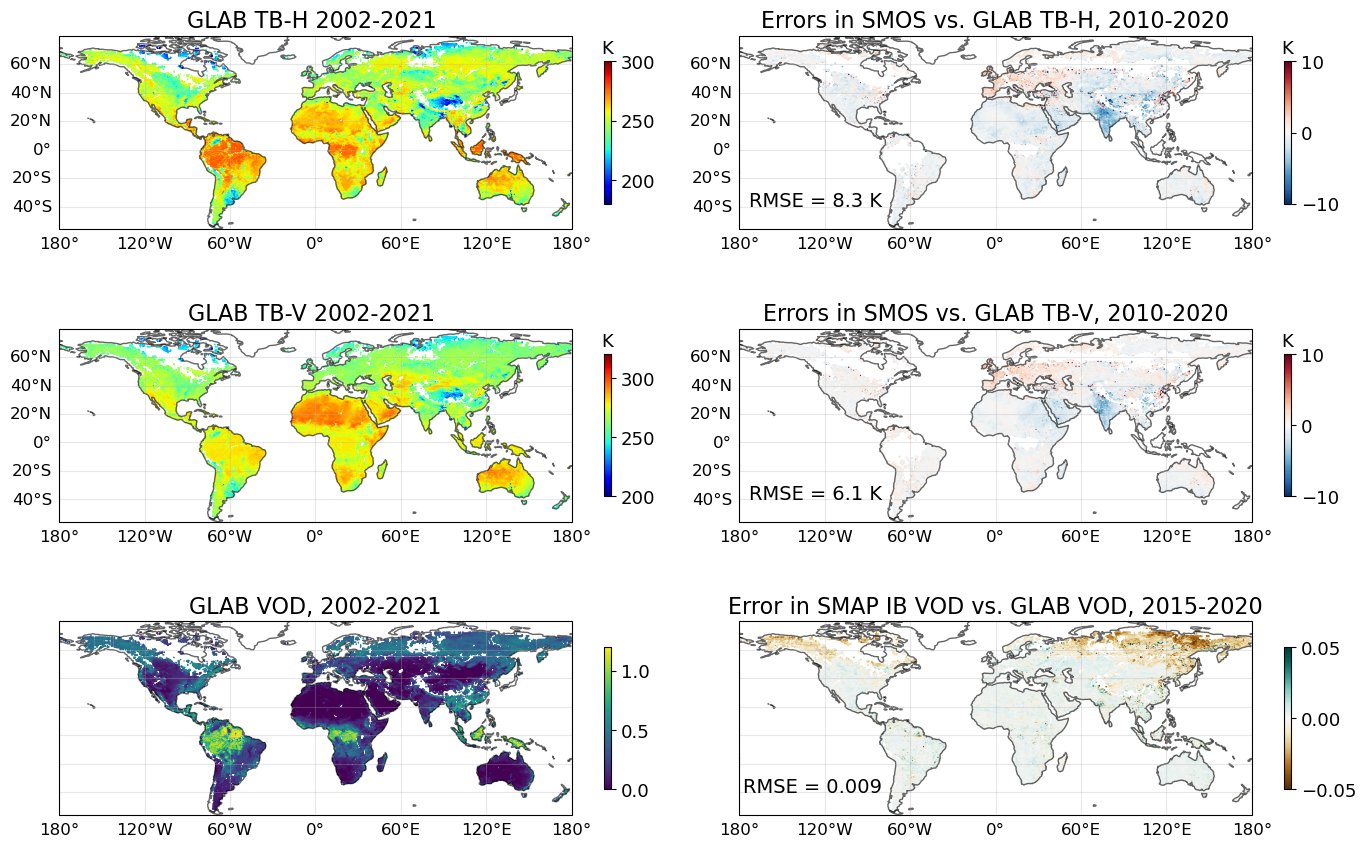

In [104]:
fig = plt.figure(figsize=(14, 9))
sr = 0.5
ax = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree())
plot_one_map(smos_map_h, 'nn_out_H-cs', 180, 300, 'jet', sr, 'GLAB TB-H 2002-2021 ', bar_title = True, 
             text = False, er = '', no_left_labels = False)

ax = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree())

plot_one_map(out_vod_map , 'str_mean', -0.0, 1.2, 'viridis', sr, 'GLAB VOD, 2002-2021', 
             bar_title = False, text = False, er = '',no_left_labels = True)

ax = fig.add_subplot(3, 2, 2, projection=ccrs.PlateCarree())
plot_one_map(smos_cut_h, 'dif_H', -10, 10, 'RdBu_r', sr, 'Errors in SMOS vs. GLAB TB-H, 2010-2020', bar_title = True, text = True, er = 'RMSE = 8.3 K', no_left_labels = False)

ax = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree())

plot_one_map(comb_vod, 'dif', -0.05, 0.05, 'BrBG', sr, 'Error in SMAP IB VOD vs. GLAB VOD, 2015-2020', bar_title = False, text = True, er = 'RMSE = 0.009',no_left_labels = True)

ax = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree())
plot_one_map(smos_map, 'nn_out_V-cs', 200, 320, 'jet', sr, 'GLAB TB-V 2002-2021 ', bar_title = True, 
             text = False, er = '', no_left_labels = False)

ax = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree())
plot_one_map(smos_cut, 'dif_V', -10, 10, 'RdBu_r', sr, 'Errors in SMOS vs. GLAB TB-V, 2010-2020', bar_title = True, text = True, er = 'RMSE = 6.1 K', no_left_labels = False)


fig.tight_layout()
plt.savefig('TB_andVOD2002_and_errors.png', dpi = 500, bbox_inches='tight')

plt.show()

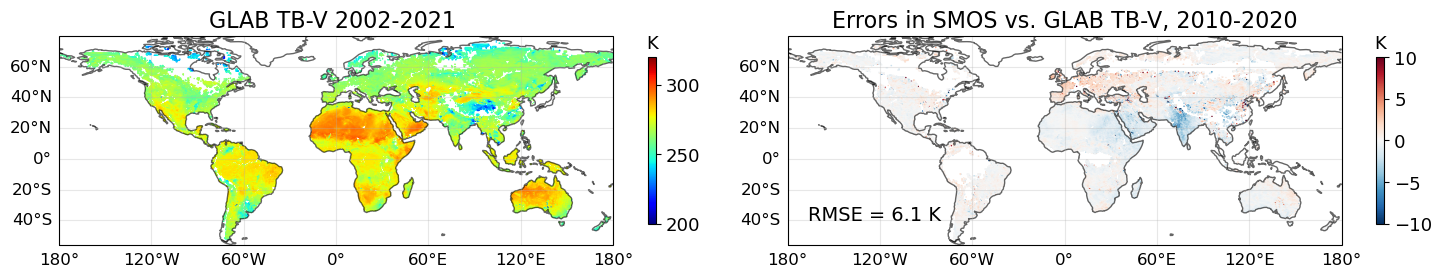

In [94]:
fig = plt.figure(figsize=(15, 4))
sr = 0.45
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
plot_one_map(smos_map, 'nn_out_V-cs', 200, 320, 'jet', sr, 'GLAB TB-V 2002-2021 ', bar_title = True, 
             text = False, er = '', no_left_labels = False)

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
plot_one_map(smos_cut, 'dif_V', -10, 10, 'RdBu_r', sr, 'Errors in SMOS vs. GLAB TB-V, 2010-2020', bar_title = True, text = True, er = 'RMSE = 6.1 K', no_left_labels = False)



fig.tight_layout()
plt.savefig('TB_V_and_errors.png', dpi = 500, bbox_inches='tight')

plt.show()

In [106]:
# vod before 2010 vs. vod after 2012


vod_10 = all_vod_t[all_vod_t['time']<'2010-01-01']

vod12 = all_vod_t[all_vod_t['time']>'2012-01-01']

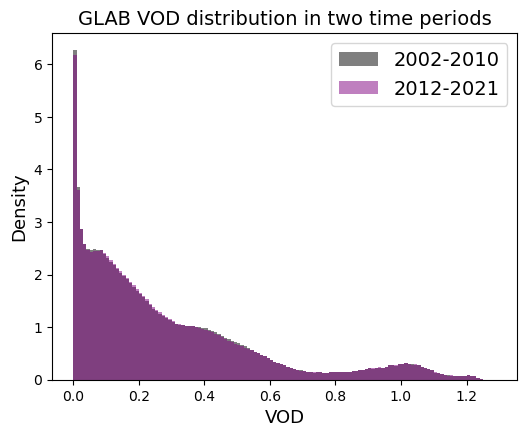

In [129]:
fig = plt.figure(figsize=(6, 4.5))

plt.hist(vod_10['str_mean'],  bins=np.arange(0, 1.3, 0.01), density = True, color = 'black', alpha = 0.5, label = '2002-2010')
plt.hist(vod12['str_mean'],  bins=np.arange(0, 1.3, 0.01), density = True, color = 'purple', alpha = 0.5, label = '2012-2021')
plt.title('GLAB VOD distribution in two time periods', fontsize=14)
plt.legend(loc = 'upper right', fontsize=14)#
plt.xlabel('VOD',  fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.savefig('20102012_HISTOGRAMS.png', dpi = 500, bbox_inches='tight')
plt.show()

In [10]:
# seasonal cycle 
smos_out['sc_h'] = smos_out['BT_H_IC_Fitted'] - smos_out['dev_H']
smos_out['sc_v'] = smos_out['BT_V_IC_Fitted'] - smos_out['dev_V']
       

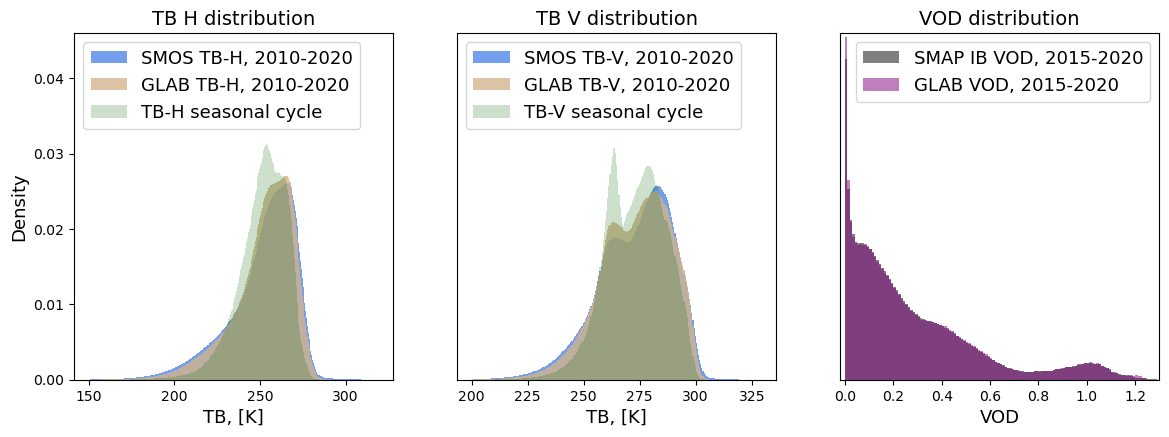

In [11]:
fig = plt.figure(figsize=(14, 4.5))

ax = fig.add_subplot(1, 3, 1)

plt.hist(smos_out['BT_H_IC_Fitted'], bins=np.arange(150, 320, 0.5), density = True, color = 'cornflowerblue', alpha = 0.9, label = 'SMOS TB-H, 2010-2020')
plt.hist(smos_out['nn_out_H_full'], bins=np.arange(150, 320, 0.5),  density = True, color = 'tan', alpha = 0.8, label = 'GLAB TB-H, 2010-2020')
plt.hist(smos_out['sc_h'], bins=np.arange(150, 320, 0.5), density = True, color = 'darkgreen', alpha = 0.2, label = 'TB-H seasonal cycle')

plt.title('TB H distribution',  fontsize=14)
plt.legend(loc = 'upper left', fontsize=13)
plt.ylabel ('Density',  fontsize=13)
plt.xlabel('TB, [K]', fontsize=13)
plt.ylim([0, 0.046])
#plt.yticks([])


ax = fig.add_subplot(1, 3, 2)

plt.hist(smos_out['BT_V_IC_Fitted'], bins=np.arange(200, 330, 0.5), density = True, color = 'cornflowerblue', alpha = 0.9, label = 'SMOS TB-V, 2010-2020')
plt.hist(smos_out['nn_out_V_full'], bins=np.arange(200, 330, 0.5),  density = True, color = 'tan', alpha = 0.8, label = 'GLAB TB-V, 2010-2020')
plt.hist(smos_out['sc_v'], bins=np.arange(200, 330, 0.5), density = True, color = 'darkgreen', alpha = 0.2, label = 'TB-V seasonal cycle')

plt.title('TB V distribution',  fontsize=14)
plt.legend(loc = 'upper left', fontsize=13)
plt.xlabel('TB, [K]', fontsize=13)
plt.ylim([0, 0.046])
plt.yticks([])


ax = fig.add_subplot(1, 3, 3)
plt.hist(combined['Optical_Thickness_Nad'], bins=np.arange(0, 1.3, 0.01), density = True, color = 'black', alpha = 0.5, label = 'SMAP IB VOD, 2015-2020')
plt.hist(combined['str_mean'], bins=np.arange(0, 1.3, 0.01),  density = True, color = 'purple', alpha = 0.5, label = 'GLAB VOD, 2015-2020')
plt.xlim([-0.02, 1.3])
plt.ylim([0, 6.2])
plt.xlabel('VOD', fontsize=13)
plt.yticks([])
plt.title('VOD distribution', fontsize=14)
plt.legend(loc = 'upper right', fontsize=13)#
plt.savefig('TB_andVOD_HISTOGRAMS.png', dpi = 500, bbox_inches='tight')

plt.show()


In [155]:
def to_resol(vod_last, m):
    vod_last = vod_last.set_index(['lat', 'lon', 'time'])
    vod_last = vod_last.to_xarray()
    vod_last = vod_last.resample(time=m).mean(dim='time')
    vod_last = vod_last.to_dataframe().reset_index()
    return vod_last

In [49]:
vod_map = combined.groupby(['lat', 'lon'])[['Optical_Thickness_Nad']].mean()
vod_map = vod_map.reset_index()

In [11]:
full_V = pd.read_pickle(path_to_files +'TB_V_out_from_TB_with_TL_2002_target_scaling_rob.pkl')
full_V.head()


lat        lon       time  out_resid_V-cs  nn_out_V-cs
0  45.416233  22.435158 2002-06-19        0.771040   273.284606
1  45.416233  22.435158 2004-06-18       -3.928517   268.585049
2  45.416233  22.435158 2006-06-19        0.410941   272.924507
3  45.416233  22.435158 2007-06-19        0.681106   273.194672
4  45.416233  22.435158 2009-06-19       -2.907376   269.606189

In [5]:
V_map = full_V.groupby(['lat', 'lon'])[['nn_out_V-cs']].mean()
V_map = V_map.reset_index()

In [34]:
full_H = pd.read_pickle(path_to_files +'TB_H_out_from_TB_with_TL_2002_target_scaling_rob.pkl')
H_map = full_H.groupby(['lat', 'lon'])[['nn_out_H-cs']].mean()
H_map = H_map.reset_index()

In [9]:
comb['dif'] = comb['BT_V_IC_Fitted']-comb['nn_out_V-cs']

In [36]:
combH = smos_map.merge(H_map, on = ['lat', 'lon'])
combH['dif'] = combH['BT_H_IC_Fitted']-combH['nn_out_H-cs']

In [40]:
vod_out_map = combined.groupby(['lat', 'lon'])[['Optical_Thickness_Nad']].mean().reset_index()
comb_2vod = vod_out_map.merge(out_vod_map, on = ['lat', 'lon'])
comb_2vod['dif'] = comb_2vod['Optical_Thickness_Nad']-comb_2vod['str_mean']

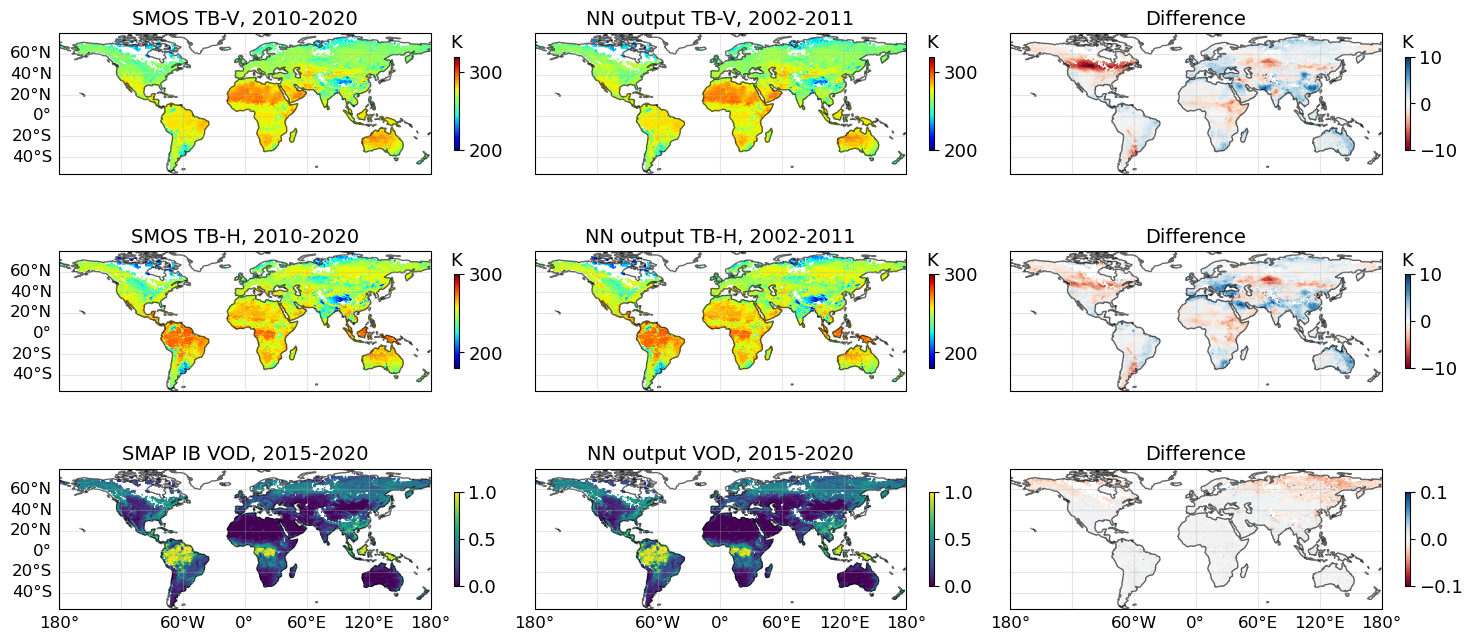

In [83]:
fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(3, 3, 1, projection=ccrs.PlateCarree())
plot_one_map(smos_map, 'BT_V_IC_Fitted', 200, 320, 'jet', sr, 'SMOS TB-V, 2010-2020', bar_title = True, no_left_labels = False, no_bottom_labels = True)


ax = fig.add_subplot(3, 3, 2, projection=ccrs.PlateCarree())
plot_one_map(V_map, 'nn_out_V-cs', 200, 320, 'jet', sr, 'NN output TB-V, 2002-2011', bar_title = True, no_left_labels = True, no_bottom_labels = True)


ax = fig.add_subplot(3, 3, 3, projection=ccrs.PlateCarree())

plot_one_map(comb, 'dif', -10, 10, 'RdBu', sr, 'Difference', bar_title = True, no_left_labels = True, no_bottom_labels = True)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.PlateCarree())

plot_one_map(smos_map, 'BT_H_IC_Fitted', 180, 300, 'jet', sr, 'SMOS TB-H, 2010-2020', bar_title = True, no_left_labels = False, no_bottom_labels = True)


ax = fig.add_subplot(3, 3, 5, projection=ccrs.PlateCarree())

plot_one_map(H_map, 'nn_out_H-cs', 180, 300, 'jet', sr, 'NN output TB-H, 2002-2011', bar_title = True, no_left_labels = True, no_bottom_labels = True)

ax = fig.add_subplot(3, 3, 6, projection=ccrs.PlateCarree())

plot_one_map(combH, 'dif', -10, 10, 'RdBu', sr, 'Difference', bar_title = True, no_left_labels = True, no_bottom_labels = True)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.PlateCarree())

plot_one_map(comb_vod, 'Optical_Thickness_Nad', 0, 1.0, 'viridis', sr, 'SMAP IB VOD, 2015-2020', bar_title = False, no_left_labels = False)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.PlateCarree())

plot_one_map(comb_vod, 'str_mean', 0, 1.0, 'viridis', sr, 'NN output VOD, 2015-2020', bar_title = False, no_left_labels = True)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.PlateCarree())

plot_one_map(comb_vod, 'dif', -0.10, 0.10, 'RdBu', sr, 'Difference', bar_title = False, no_left_labels = True)

fig.tight_layout()
plt.savefig('errors_and_patterns.png', dpi = 500, bbox_inches='tight')

plt.show()

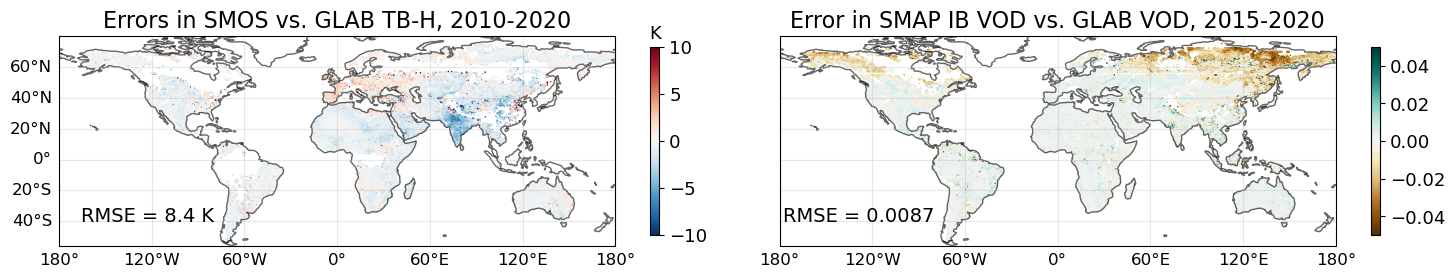

In [43]:
fig = plt.figure(figsize=(15, 5))
sr = 0.4
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
plot_one_map(smos_cut, 'dif_H', -10, 10, 'RdBu_r', sr, 'Errors in SMOS vs. GLAB TB-H, 2010-2020', bar_title = True, text = True, er = 'RMSE = 8.4 K', no_left_labels = False)

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

plot_one_map(comb_vod, 'dif', -0.05, 0.05, 'BrBG', sr, 'Error in SMAP IB VOD vs. GLAB VOD, 2015-2020', bar_title = False, text = True, er = 'RMSE = 0.0087',no_left_labels = True)

fig.tight_layout()
plt.savefig('errors_inTB_andVOD.png', dpi = 500, bbox_inches='tight')

plt.show()

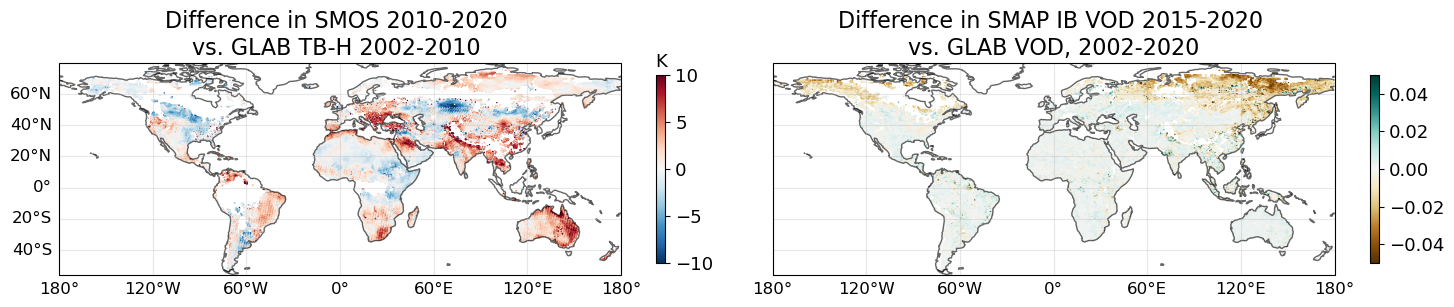

In [90]:
fig = plt.figure(figsize=(15, 5))
sr = 0.4
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
plot_one_map(combH, 'dif', -10, 10, 'RdBu_r', sr, 'Difference in SMOS 2010-2020 \nvs. GLAB TB-H 2002-2010 ', bar_title = True, 
             text = False, er = '', no_left_labels = False)

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

plot_one_map(combined_map, 'dif', -0.05, 0.05, 'BrBG', sr, 'Difference in SMAP IB VOD 2015-2020 \nvs. GLAB VOD, 2002-2020', 
             bar_title = False, text = False, er = '',no_left_labels = True)

fig.tight_layout()
plt.savefig('errors_inTB_andVOD2002.png', dpi = 500, bbox_inches='tight')

plt.show()

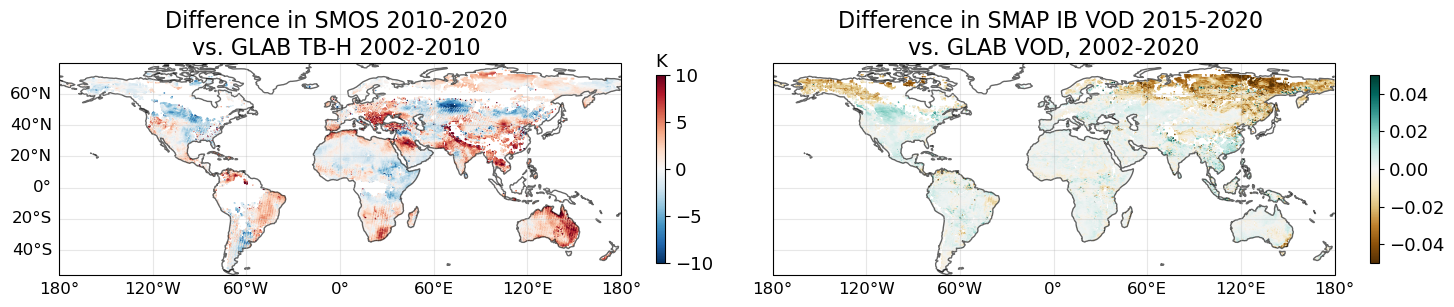

In [46]:
fig = plt.figure(figsize=(15, 5))
sr = 0.4
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
plot_one_map(combH, 'dif', -10, 10, 'RdBu_r', sr, 'Difference in SMOS 2010-2020 \nvs. GLAB TB-H 2002-2010 ', bar_title = True, 
             text = False, er = '', no_left_labels = False)

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

plot_one_map(vod_out_map, 'str_mean', -0.0, 1.2, 'viridis', sr, 'GLAB VOD, 2002-2020', 
             bar_title = False, text = False, er = '',no_left_labels = True)

fig.tight_layout()
plt.savefig('TB_andVOD2002.png', dpi = 500, bbox_inches='tight')

plt.show()

In [142]:
one_out_north3 = slice_coor(all_vod_t, -2.93, -75.28)

(52056, 7)
[-2.84551334]
(367, 7)
[-75.34581757]


In [143]:
one_vod_north3 = slice_coor(smos,  -2.93, -75.28)

(162831, 10)
[-2.84551334]
(897, 10)
[-75.34581757]


In [144]:
one_vod_north3.reset_index(drop=True, inplace=True)

In [145]:
one_out_north3.reset_index(drop=True, inplace=True)

Aug 21 2017

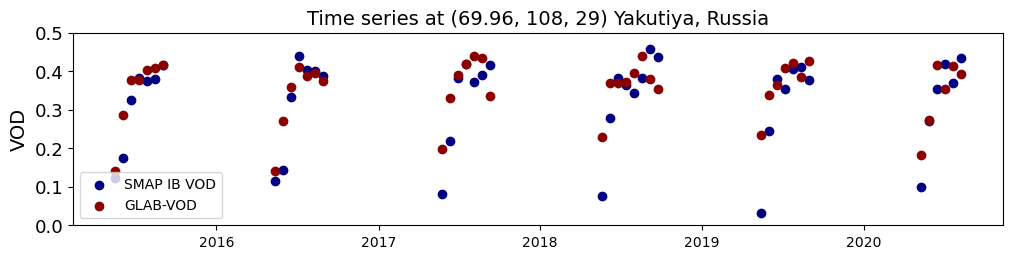

In [111]:
fig = plt.figure(figsize=(12, 2.5))
plt.scatter(one_out_north_comb['time'], one_out_north_comb['Optical_Thickness_Nad'], color = 'navy',label = 'SMAP IB VOD')

plt.scatter(one_out_north_comb['time'], one_out_north_comb['str_mean'], color = 'darkred',  label =  'GLAB-VOD')

plt.ylabel('VOD', fontsize=14)
plt.yticks(fontsize=13)
plt.ylim([0, 0.5])
plt.legend(loc = 'lower left')
plt.title('Time series at (69.96, 108, 29) Yakutiya, Russia', fontsize=14) 
plt.show()

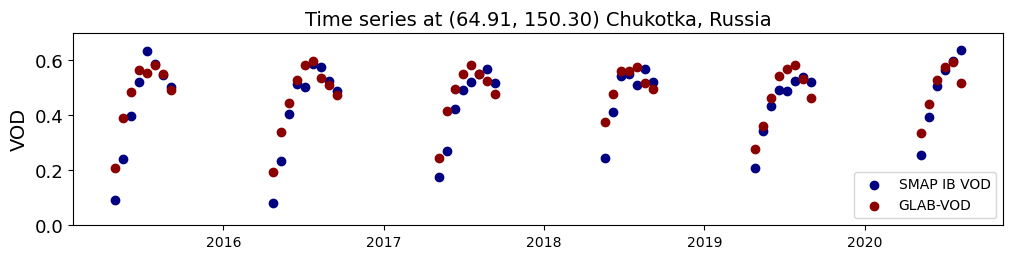

In [110]:
fig = plt.figure(figsize=(12, 2.5))
plt.scatter(one_out_north_comb1['time'], one_out_north_comb1['Optical_Thickness_Nad'], color = 'navy',label = 'SMAP IB VOD')

plt.scatter(one_out_north_comb1['time'], one_out_north_comb1['str_mean'], color = 'darkred',  label =  'GLAB-VOD')

plt.ylabel('VOD', fontsize=14)
plt.yticks(fontsize=13)
plt.ylim([0, 0.7])
plt.legend(loc = 'lower right')
plt.title('Time series at (64.91, 150.30) Chukotka, Russia', fontsize=14) 
plt.show()

In [35]:
lats = [90, 60, 30, 0, -30, -60]

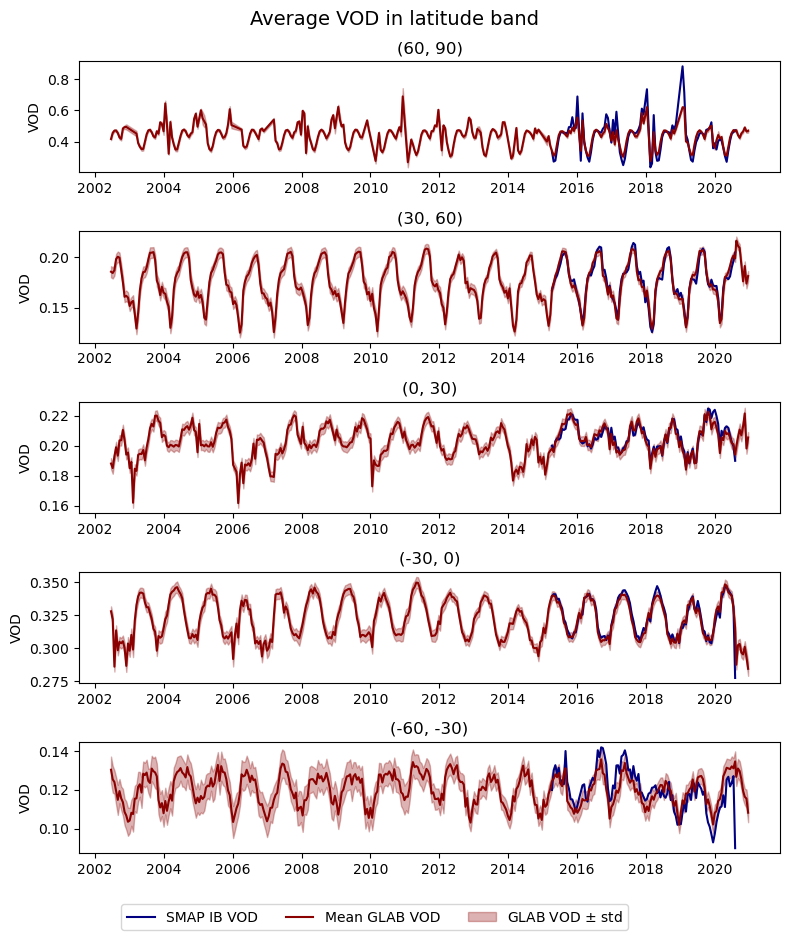

In [39]:
fig = plt.figure(figsize=(8, 9))


for i in range(5):
    lat_m = lats[i+1]
    lat_M = lats[i]
    transfer_cut =combined[combined['lat']<lat_M]
    transfer_cut = transfer_cut[transfer_cut['lat']>lat_m]
    ts_tr = transfer_cut.groupby('time')['Optical_Thickness_Nad'].mean()
    ts_tr = ts_tr.reset_index()
  
    transfer =all_vod_t[all_vod_t['lat']<lat_M]
    transfer = transfer[transfer['lat']>lat_m]
    ts_tr2 = transfer.groupby('time')[['str_mean', 'str_std']].mean()
    ts_tr2 = ts_tr2.reset_index()
    
    transfer =all_vod_t[all_vod_t['lat']<lat_M]
    transfer = transfer[transfer['lat']>lat_m]
    ts_tr3 = transfer.groupby('time')[['str_mean', 'str_std']].mean()
    ts_tr3 = ts_tr3.reset_index()
    
    ts_tr2['minus'] = ts_tr2['str_mean']-ts_tr2['str_std']
    ts_tr2['plus'] = ts_tr2['str_mean']+ts_tr2['str_std']
    ts_tr3['minus'] = ts_tr3['str_mean']-ts_tr3['str_std']
    ts_tr3['plus'] = ts_tr3['str_mean']+ts_tr3['str_std']
    ax = fig.add_subplot(5, 1, i+1)
    plt.plot(ts_tr['time'], ts_tr['Optical_Thickness_Nad'], color = 'navy')
    #plt.plot(ts_tr3['time'], ts_tr3['str_mean'], color = 'goldenrod', label = 'VOD NNout mean extended')
    #plt.fill_between(ts_tr3['time'], ts_tr3['minus'], ts_tr3['plus'], color = 'tan', alpha = 0.3, label = 'VOD $\pm$ std')

    plt.plot(ts_tr2['time'], ts_tr2['str_mean'], color = 'darkred')

    plt.fill_between(ts_tr2['time'], ts_tr2['minus'], ts_tr2['plus'], color = 'darkred', alpha = 0.3)

#ts.vod.plot()
    plt.ylabel('VOD')
    plt.title('(' + str(lat_m) + ', ' + str(lat_M) + ')')
plt.suptitle('Average VOD in latitude band', fontsize = 14)

fig.legend(['SMAP IB VOD', 'Mean GLAB VOD', 'GLAB VOD $\pm$ std'],loc='lower right', bbox_to_anchor=(0.8,-0.05), ncol=3)    
        
fig.tight_layout()
plt.savefig('4ts_vod.png', dpi = 500, bbox_inches='tight')
    
plt.show()

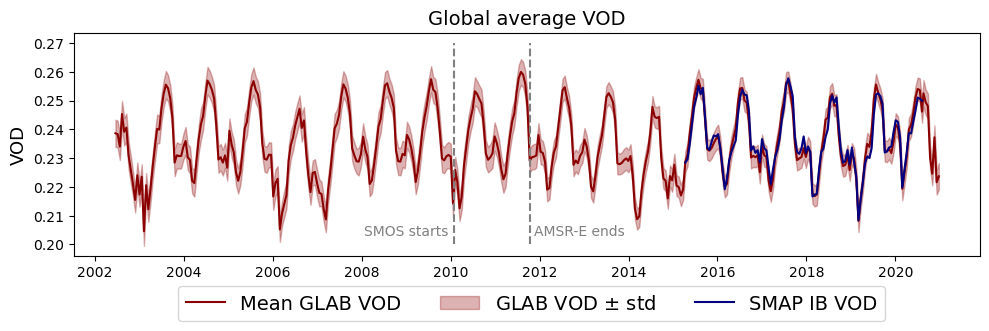

In [40]:
fig = plt.figure(figsize=(10, 3))


ts_tr = combined.groupby('time')['Optical_Thickness_Nad'].mean()
ts_tr = ts_tr.reset_index()

ts_tr2 = all_vod_t.groupby('time')[['str_mean', 'str_std']].mean()
ts_tr2 = ts_tr2.reset_index()
    

    
ts_tr2['minus'] = ts_tr2['str_mean']-ts_tr2['str_std']
ts_tr2['plus'] = ts_tr2['str_mean']+ts_tr2['str_std']

    #plt.plot(ts_tr3['time'], ts_tr3['str_mean'], color = 'goldenrod', label = 'VOD NNout mean extended')
    #plt.fill_between(ts_tr3['time'], ts_tr3['minus'], ts_tr3['plus'], color = 'tan', alpha = 0.3, label = 'VOD $\pm$ std')

plt.plot(ts_tr2['time'], ts_tr2['str_mean'], color = 'darkred')

plt.fill_between(ts_tr2['time'], ts_tr2['minus'], ts_tr2['plus'], color = 'darkred', alpha = 0.3)
plt.plot(ts_tr['time'], ts_tr['Optical_Thickness_Nad'], color = 'navy')
#smos starts 2010-01-13 2011-10-02
plt.vlines(14638, 0.2, 0.27, linestyle = '--', color = 'grey')
plt.text(13900, 0.203, 'SMOS starts', color = 'grey')
plt.vlines(14638+627, 0.2, 0.27, linestyle = '--', color = 'grey')
plt.text(15297, 0.203, 'AMSR-E ends', color = 'grey')
#ts.vod.plot()
plt.ylabel('VOD', fontsize=13)
plt.title('Global average VOD', fontsize=14)
fig.legend([ 'Mean GLAB VOD', 'GLAB VOD $\pm$ std', 'SMAP IB VOD'],loc='lower right', bbox_to_anchor=(0.9,-0.12), ncol=3, fontsize=14)    
        
fig.tight_layout()
plt.savefig('global_ts_vod_with_lines.png', dpi = 500, bbox_inches='tight')
    
plt.show()

smos is wrong on so many levels
what if I do the opposite - apply smos_vod TBh seas cycle to larger smos?

In [151]:
def slice_coor(data, lat, lon):
    one_loc = data[abs(data['lat']-lat)< 0.1]
    print(one_loc.shape)
    print(np.unique(one_loc['lat']))
    one_loc = one_loc[abs(one_loc['lon']-lon)<0.12]
    print(one_loc.shape)
    print(np.unique(one_loc['lon']))    
    return one_loc

In [42]:
def slice_box(data, lat_m, lon_m, lat_M, lon_M):
    one_loc = data[data['lat']<lat_M]
    one_loc = one_loc[one_loc['lat']>lat_m]
    one_loc = one_loc[one_loc['lon']<lon_M]
    one_loc = one_loc[one_loc['lon']>lon_m]
    print(one_loc.shape)   
    return one_loc

In [43]:
n_amazon_r = slice_box(combined, -10, -80, 5, -60)

s_amazon_r = slice_box(combined, -20, -60, -10, -40)
china_r = slice_box(combined, 10, 90, 30, 110)
africa_r = slice_box(combined, -30, 13, -10, 33)
n_us_r = slice_box(combined, 40, -90, 50, -70)
s_us_r = slice_box(combined, 25, -120, 35, -100)
eu_r = slice_box(combined, 35, -10, 50, 5)
siberia_r = slice_box(combined, 40, 60, 60, 90)
australia_r = slice_box(combined, -30, 120, -15, 140)

(408524, 8)
(312210, 8)
(123139, 8)
(635847, 8)
(87574, 8)
(191870, 8)
(113964, 8)
(369810, 8)
(482499, 8)


In [44]:
n_amazon = slice_box(all_vod_t, -10, -80, 5, -60)
s_amazon = slice_box(all_vod_t, -20, -60, -10, -40)
china = slice_box(all_vod_t, 10, 90, 30, 110)

africa = slice_box(all_vod_t, -30, 13, -10, 33)
n_us = slice_box(all_vod_t, 40, -90, 50, -70)
s_us = slice_box(all_vod_t, 25, -120, 35, -100)

eu = slice_box(all_vod_t, 35, -10, 50, 5)
siberia = slice_box(all_vod_t, 40, 60, 60, 90)
australia = slice_box(all_vod_t, -30, 120, -15, 140)

(1400705, 7)
(1076280, 7)
(414818, 7)
(2200020, 7)
(291902, 7)
(662336, 7)
(397514, 7)
(1240355, 7)
(1675186, 7)


In [45]:
congo = slice_box(all_vod_t, -4.4, 10, 2.2, 20)
congo_r =  slice_box(combined, -4.4, 10, 2.2, 20)

(224682, 7)
(66733, 8)


In [154]:
one_minus30 = slice_coor(all_vod_t, -50, -70)
one_minus30

In [162]:
one_minus30_r = slice_coor(combined, -50, -70)


(1085, 8)
[-50.0498848]
(108, 8)
[-69.89913177]


In [163]:
one_alaska = slice_coor(all_vod_t, 65, -153)
one_alaska_r = slice_coor(combined, 65, -153)


(77581, 7)
[64.91255188]
(199, 7)
[-152.89625549]
(23673, 8)
[64.91255188]
(61, 8)
[-152.89625549]


In [170]:
one_ny = slice_coor(all_vod_t, 44.5, 0.5)
one_ny_r = slice_coor(combined, 44.5, 0.5)


(126234, 7)
[44.58949661]
(374, 7)
[0.38904899]
(37816, 8)
[44.58949661]
(108, 8)
[0.38904899]


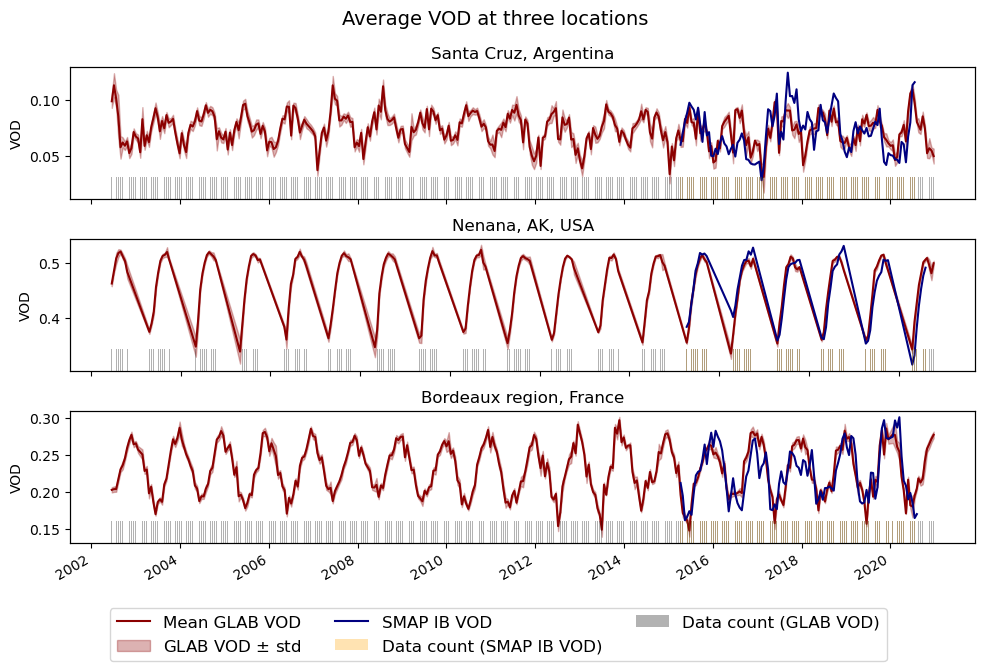

In [174]:
list_of = [ one_minus30,  one_alaska, one_ny]
list_of_r = [ one_minus30_r, one_alaska_r, one_ny_r]
names = [ 'Santa Cruz, Argentina',  'Nenana, AK, USA', 'Bordeaux region, France'] 
colors = ['green', 'limegreen', 'red', 'chocolate', 'orange', 'navy', 'steelblue', 'blueviolet', 'grey', 'brown' ]         


fig = plt.figure(figsize=(10, 6))


for i in range(3):
    vod_our = list_of[i] 
    vod_raw = list_of_r[i]
    ts_tr = vod_raw.groupby('time')['Optical_Thickness_Nad'].agg(['mean','count'])
    ts_tr = ts_tr.reset_index()
    ts_tr = ts_tr.dropna()
  
    ts_tr2 = vod_our.groupby('time')[['str_mean', 'str_std']].mean()
    ts_tr2 = ts_tr2.reset_index()
    ts_tr2 = ts_tr2.dropna()
    ts_tr3 = vod_our.groupby('time')['str_mean'].count()
    ts_tr3 = ts_tr3.reset_index()
    ts_tr3 = ts_tr3.dropna()

    ts_tr2['minus'] = ts_tr2['str_mean']-ts_tr2['str_std']
    ts_tr2['plus'] = ts_tr2['str_mean']+ts_tr2['str_std']
    ax = fig.add_subplot(3, 1, i+1)
    plt.plot(ts_tr2['time'], ts_tr2['str_mean'], color = 'darkred', label = 'VOD NNout mean')
    plt.fill_between(ts_tr2['time'], ts_tr2['minus'], ts_tr2['plus'], color = 'darkred', alpha = 0.3, label = 'VOD $\pm$ std')
    plt.plot(ts_tr['time'], ts_tr['mean'], color = 'navy', label = 'VOD data')

    plt.gcf().autofmt_xdate()

#ts.vod.plot()
    plt.ylabel('VOD')
    plt.title(names[i] )

    
    ax = plt.gca()
    ax2 = ax.twinx()


    ax2.bar(ts_tr['time'], ts_tr['count'], width = 6, alpha = 0.3, fc = 'orange', edgecolor='none', label = 'count in Training dataset')
    ax2.bar(ts_tr3['time'], ts_tr3['str_mean'], width = 6, fc = 'black', alpha = 0.3, edgecolor='none', label = 'count in NN output')

    if i+1%3==0:
        ax2.set_ylabel('count')
    else:
        ax2.set_ylabel('')
        ax2.set_yticks([])
        
    ax2.set_ylim([0, 6*np.max(ts_tr3['str_mean'])])
plt.suptitle('Average VOD at three locations', fontsize = 14 )

    
fig.legend(['Mean GLAB VOD', 'GLAB VOD $\pm$ std', 'SMAP IB VOD', 'Data count (SMAP IB VOD)', 'Data count (GLAB VOD)'], loc='lower right', bbox_to_anchor=(0.9,-0.12), ncol=3, fontsize=12)    

        
    
fig.tight_layout()
plt.savefig('2ts_vod.pdf', bbox_inches='tight')
    
plt.show()

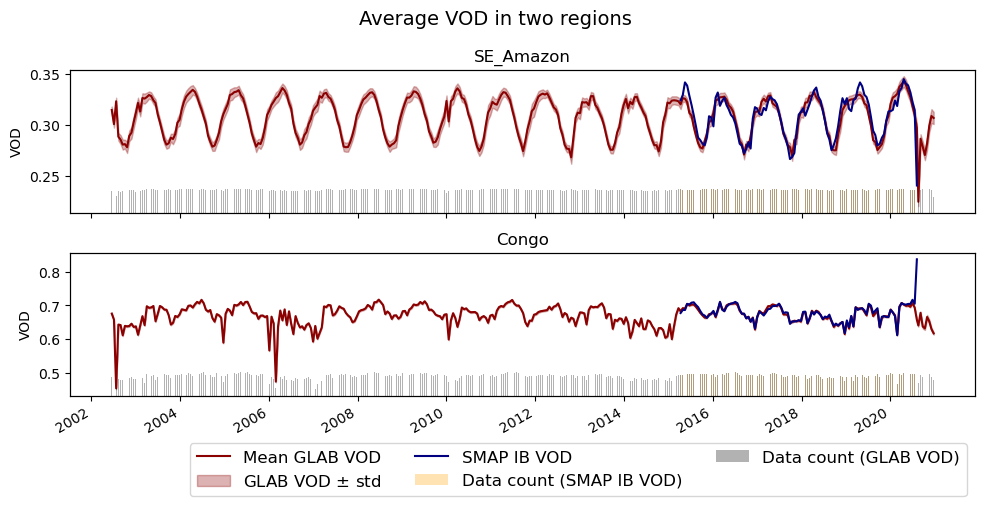

In [47]:
list_of = [ s_amazon,  congo]
list_of_r = [ s_amazon_r, congo_r]
names = [ 'SE_Amazon',  'Congo'] 
colors = ['green', 'limegreen', 'red', 'chocolate', 'orange', 'navy', 'steelblue', 'blueviolet', 'grey', 'brown' ]         


fig = plt.figure(figsize=(10, 4.5))


for i in range(2):
    vod_our = list_of[i] 
    vod_raw = list_of_r[i]
    ts_tr = vod_raw.groupby('time')['Optical_Thickness_Nad'].agg(['mean','count'])
    ts_tr = ts_tr.reset_index()
    ts_tr = ts_tr.dropna()
  
    ts_tr2 = vod_our.groupby('time')[['str_mean', 'str_std']].mean()
    ts_tr2 = ts_tr2.reset_index()
    ts_tr2 = ts_tr2.dropna()
    ts_tr3 = vod_our.groupby('time')['str_mean'].count()
    ts_tr3 = ts_tr3.reset_index()
    ts_tr3 = ts_tr3.dropna()

    ts_tr2['minus'] = ts_tr2['str_mean']-ts_tr2['str_std']
    ts_tr2['plus'] = ts_tr2['str_mean']+ts_tr2['str_std']
    ax = fig.add_subplot(2, 1, i+1)
    plt.plot(ts_tr2['time'], ts_tr2['str_mean'], color = 'darkred', label = 'VOD NNout mean')
    plt.fill_between(ts_tr2['time'], ts_tr2['minus'], ts_tr2['plus'], color = 'darkred', alpha = 0.3, label = 'VOD $\pm$ std')
    plt.plot(ts_tr['time'], ts_tr['mean'], color = 'navy', label = 'VOD data')

    plt.gcf().autofmt_xdate()

#ts.vod.plot()
    plt.ylabel('VOD')
    plt.title(names[i] )

    
    ax = plt.gca()
    ax2 = ax.twinx()


    ax2.bar(ts_tr['time'], ts_tr['count'], width = 6, alpha = 0.3, fc = 'orange', edgecolor='none', label = 'count in Training dataset')
    ax2.bar(ts_tr3['time'], ts_tr3['str_mean'], width = 6, fc = 'black', alpha = 0.3, edgecolor='none', label = 'count in NN output')

    if i+1%3==0:
        ax2.set_ylabel('count')
    else:
        ax2.set_ylabel('')
        ax2.set_yticks([])
        
    ax2.set_ylim([0, 6*np.max(ts_tr3['str_mean'])])
plt.suptitle('Average VOD in two regions', fontsize = 14 )

    
fig.legend(['Mean GLAB VOD', 'GLAB VOD $\pm$ std', 'SMAP IB VOD', 'Data count (SMAP IB VOD)', 'Data count (GLAB VOD)'], loc='lower right', bbox_to_anchor=(0.98,-0.12), ncol=3, fontsize=12)    

        
    
fig.tight_layout()
plt.savefig('2ts_vod.pdf', bbox_inches='tight')
    
plt.show()

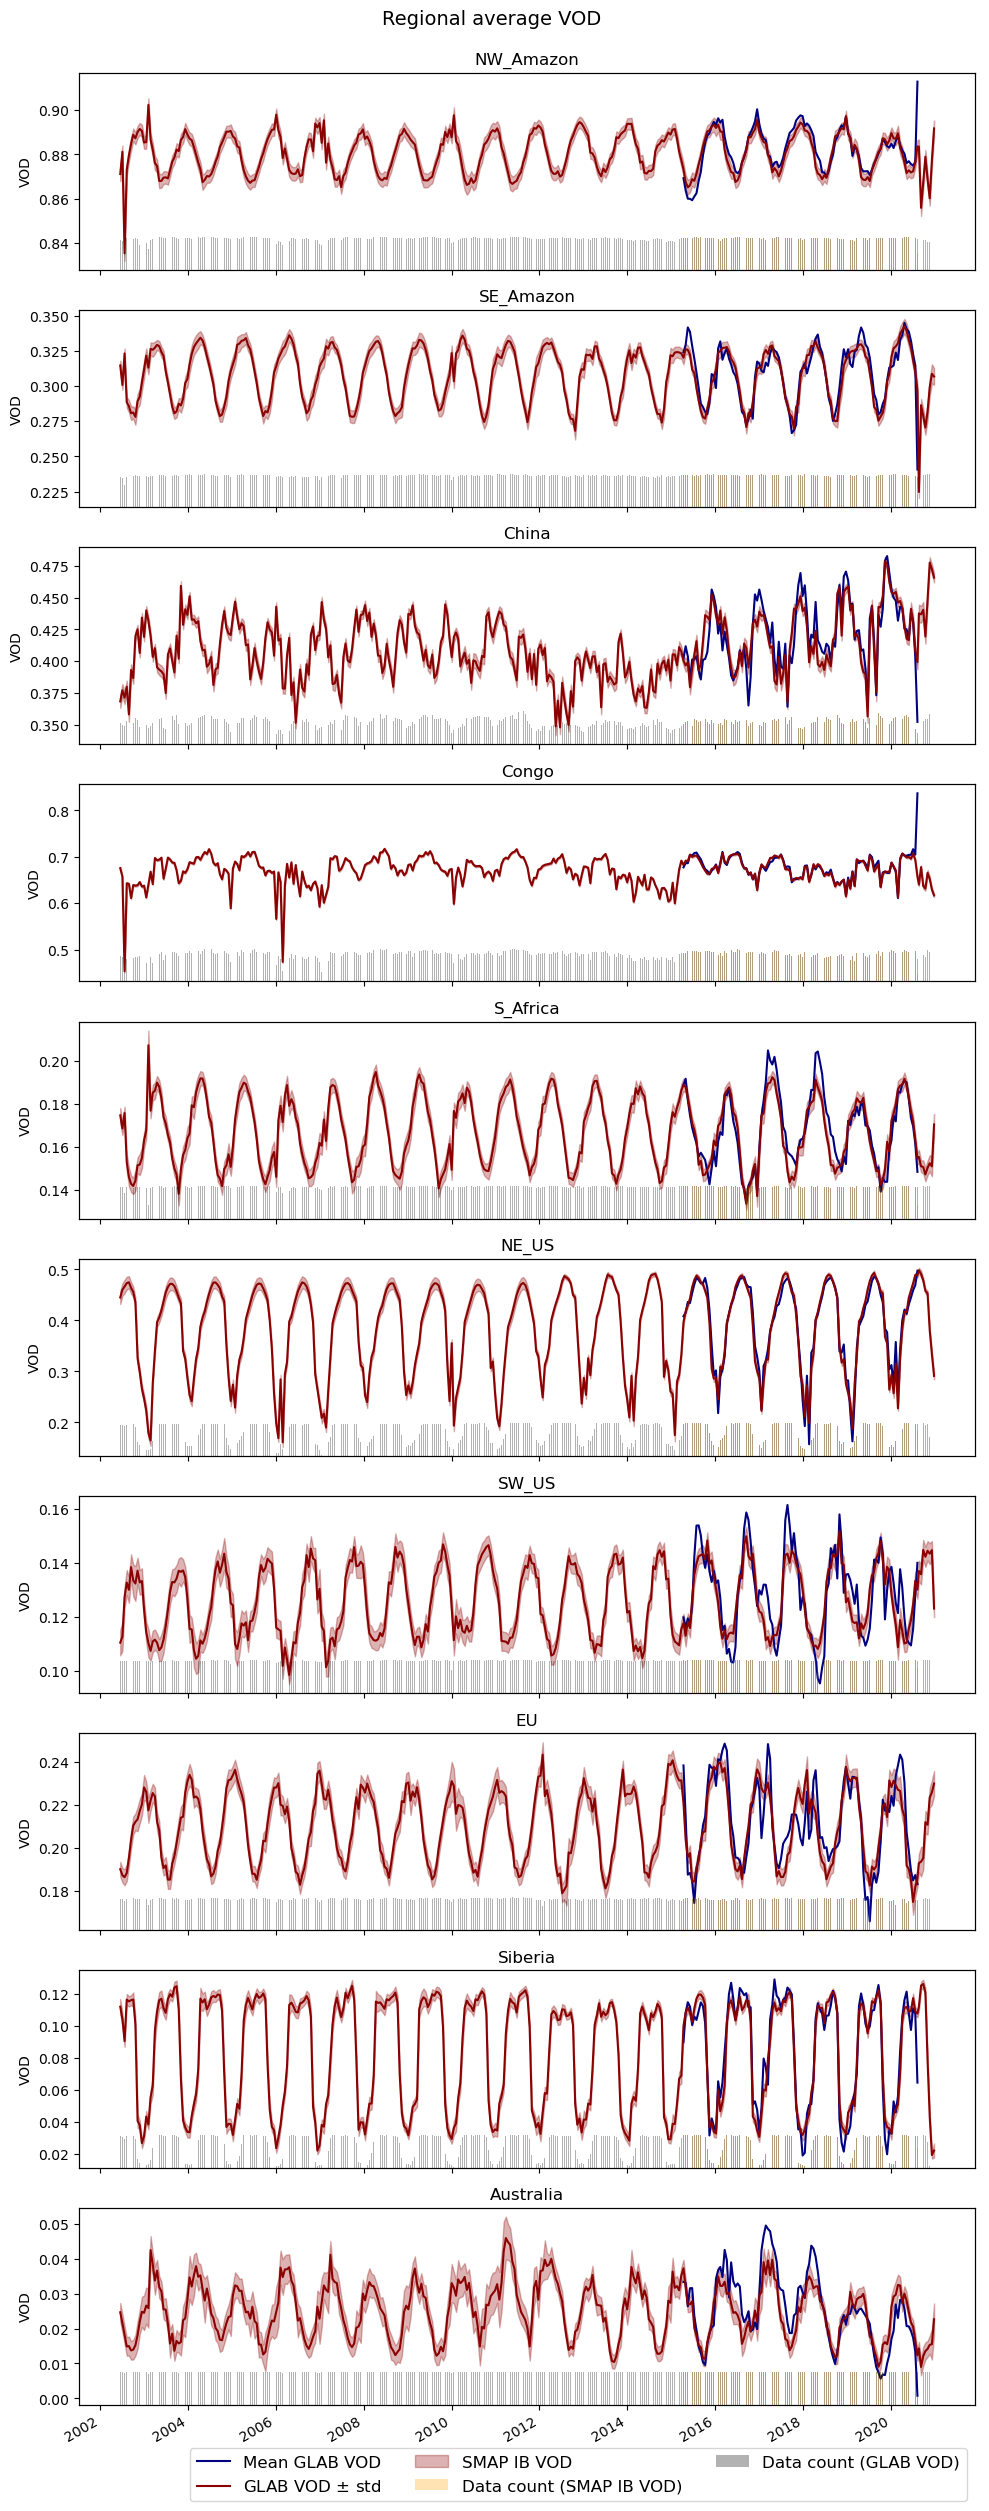

In [52]:
list_of = [n_amazon, s_amazon, china, congo, africa,  n_us, s_us,  eu, siberia, australia]
list_of_r = [n_amazon_r, s_amazon_r, china_r, congo_r, africa_r,  n_us_r, s_us_r,  eu_r, siberia_r, australia_r]
names = ['NW_Amazon', 'SE_Amazon', 'China', 'Congo', 'S_Africa', 'NE_US', 'SW_US', 'EU', 'Siberia', 'Australia'] 
colors = ['green', 'limegreen', 'red', 'chocolate', 'orange', 'navy', 'steelblue', 'blueviolet', 'grey', 'brown' ]         


fig = plt.figure(figsize=(10, 25))


for i in range(10):
    vod_our = list_of[i] 
    vod_raw = list_of_r[i]
    ts_tr = vod_raw.groupby('time')['Optical_Thickness_Nad'].agg(['mean','count'])
    ts_tr = ts_tr.reset_index()
    ts_tr = ts_tr.dropna()
  
    ts_tr2 = vod_our.groupby('time')[['str_mean', 'str_std']].mean()
    ts_tr2 = ts_tr2.reset_index()
    ts_tr2 = ts_tr2.dropna()
    ts_tr3 = vod_our.groupby('time')['str_mean'].count()
    ts_tr3 = ts_tr3.reset_index()
    ts_tr3 = ts_tr3.dropna()

    ts_tr2['minus'] = ts_tr2['str_mean']-ts_tr2['str_std']
    ts_tr2['plus'] = ts_tr2['str_mean']+ts_tr2['str_std']
    ax = fig.add_subplot(10, 1, i+1)
    plt.plot(ts_tr['time'], ts_tr['mean'], color = 'navy', label = 'VOD data')
    plt.plot(ts_tr2['time'], ts_tr2['str_mean'], color = 'darkred', label = 'VOD NNout mean')
    plt.fill_between(ts_tr2['time'], ts_tr2['minus'], ts_tr2['plus'], color = 'darkred', alpha = 0.3, label = 'VOD $\pm$ std')

    plt.gcf().autofmt_xdate()

#ts.vod.plot()
    plt.ylabel('VOD')
    plt.title(names[i] )
    
    ax = plt.gca()
    ax2 = ax.twinx()


    ax2.bar(ts_tr['time'], ts_tr['count'], width = 6, alpha = 0.3, fc = 'orange', edgecolor='none', label = 'count in Training dataset')
    ax2.bar(ts_tr3['time'], ts_tr3['str_mean'], width = 6, fc = 'black', alpha = 0.3, edgecolor='none', label = 'count in NN output')

    if i+1%3==0:
        ax2.set_ylabel('count')
    else:
        ax2.set_ylabel('')
        ax2.set_yticks([])
        
    ax2.set_ylim([0, 6*np.max(ts_tr3['str_mean'])])

    
fig.legend(['Mean GLAB VOD', 'GLAB VOD $\pm$ std', 'SMAP IB VOD', 'Data count (SMAP IB VOD)', 'Data count (GLAB VOD)'], loc='lower right', bbox_to_anchor=(0.98,-0.02), ncol=3, fontsize=12)    
plt.suptitle('Regional average VOD \n \n ', fontsize = 14 )

    
        
    
fig.tight_layout()
plt.savefig('10regions_vod.png', dpi =500, bbox_inches='tight')
    
plt.show()

In [53]:
import matplotlib.patches as mpatches

def box_and_text (lat_m, lon_m, lat_M, lon_M, text, color):
    ax.add_patch(mpatches.Rectangle(xy=[lon_m, lat_m], width=np.abs(lon_M-lon_m), height=np.abs(lat_M-lat_m),
                                    facecolor=color,
                                    alpha=0.4,
                                    transform=ccrs.PlateCarree()))
    plt.text(lon_m+5, lat_m+5,  text,
         horizontalalignment='right', #color = 'darkblue',
         transform=ccrs.Geodetic())


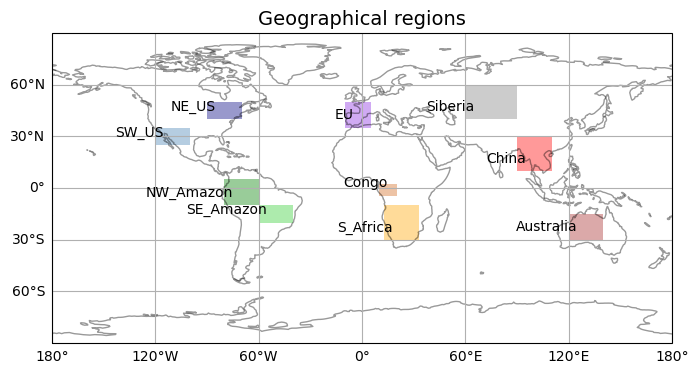

In [56]:
import matplotlib.patches as mpatches


fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(alpha = 0.4)
#ax.stock_img()

gls = ax.gridlines(draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

box_and_text(-10, -80, 5, -60, 'NW_Amazon', 'green') 
box_and_text( -20, -60, -10, -40, 'SE_Amazon', 'limegreen')

box_and_text(10, 90, 30, 110, 'China', 'red')
box_and_text(-4.4, 10, 2.2, 20, 'Congo', 'chocolate')

box_and_text(-30, 13, -10, 33, 'S_Africa', 'orange')
box_and_text(40, -90, 50, -70, 'NE_US', 'navy')
box_and_text(25, -120, 35, -100, 'SW_US', 'steelblue')
box_and_text(35, -10, 50, 5, 'EU', 'blueviolet')
box_and_text(40, 60, 60, 90, 'Siberia', 'grey')
box_and_text(-30, 120, -15, 140, 'Australia', 'brown')

plt.title ('Geographical regions', fontsize = 14)
plt.savefig('10regions_MAP.png', dpi =500, bbox_inches='tight')

plt.show()

In [60]:
# RAW SMOS TB data, averaged to 3 day mean

smos = pd.read_pickle(path_to_files + 'smos_3dm_seas_c_no_std_nothing_else.pkl')
count_tr3 = smos.groupby(['lat', 'lon'])[['BT_H_IC_Fitted']].count().reset_index()


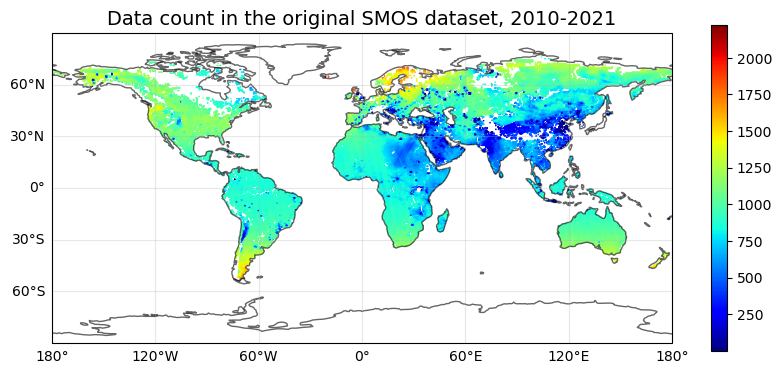

In [61]:
fig = plt.figure(figsize=(10, 6.5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
#ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
ax.coastlines(alpha = 0.6)
gls = ax.gridlines(draw_labels=True, alpha = 0.3)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels vmin=0, vmax=1  marker = '.', s=10, vmin=-0.01, vmax=0.01,
    

sm = plt.scatter(x = count_tr3['lon'], y = count_tr3 ['lat'], c=count_tr3 ['BT_H_IC_Fitted'], s=1,  cmap='jet', edgecolors=None, linewidth=0)

cb = plt.colorbar(sm, shrink=0.65)

plt.title('Data count in the original SMOS dataset, 2010-2021', fontsize = 14)

plt.savefig('datacount_smos.png', dpi =500, bbox_inches='tight')


plt.show()

In [63]:
# read Biomass data and convert to dataset

import h5py
f2 = h5py.File(path_to_files + 'AGB_Saatchi_2015.mat')

f = h5py.File(path_to_files + 'AGB_CCI_2017.mat')

In [110]:
# canopy height

bc = xr.open_dataset(path_to_files + 'canopy_height.tif')
bc

<xarray.Dataset>
Dimensions:      (band: 1, x: 720, y: 360)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [68]:

struArray1 = f['AGB_CCI']
struArray2 = f2['AGB_Saatchi']

bio = np.array(struArray)
bio2 = np.array(struArray2)

bio2 = np.flipud(bio2.T)
bio2 = np.expand_dims(bio2, axis =2)
bio2.shape

(720, 1440, 1)

In [69]:
bio = np.flipud(bio.T)
bio = np.expand_dims(bio, axis =2)
bio.shape

(720, 1440, 1)

In [37]:
reference_time = np.array([pd.Timestamp("2019-12-31")])

In [79]:
ds = xr.Dataset({
    'biomass_CCI': xr.DataArray(
        data = bio,
        dims = ['lat','lon', 'time'],
        coords = {'lat': lats, 'lon': lons, 'time': reference_time},
        attrs = {'long_name': 'CCI'}
        ),
    'biomass_saatchi': xr.DataArray(
        data = bio2,
        dims = ['lat','lon', 'time'],
        coords = {'lat': lats, 'lon': lons, 'time': reference_time},
        attrs = {'long_name': 'Saatchi'}
        )
    }
    )


In [77]:
bc.coords['lon'] = (bc.coords['lon'] + 180) % 360 - 180
bc = bc.sortby(bc.lon)
lons = bc['lon']

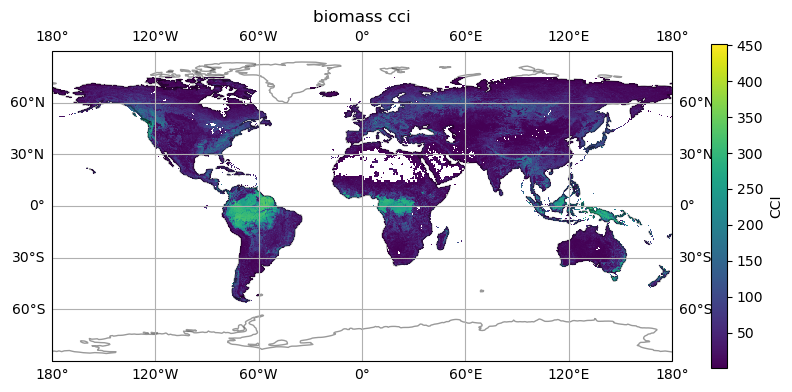

In [83]:
fig = plt.figure(figsize=(10, 7))
cbar_kwargs = {'shrink':0.6}


ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


#ds0.BT_H_IC_Fitted.plot(cmap = 'magma', cbar_kwargs=cbar_kwargs)
ds.biomass_CCI.plot(cmap = 'viridis', cbar_kwargs=cbar_kwargs)


              
ax.set_global()
ax.coastlines(alpha = 0.4)
ax.gridlines(draw_labels=True)
#plt.title('TB 1 day data 2015-04-01')
plt.title('biomass cci')


plt.show()

In [102]:
bc.to_netcdf(path_to_files + 'canopy.nc')

In [111]:
bc = bc.rename({'band': 'band_old'})

# Change the 'band_old' coordinate type and value
bc = bc.assign_coords(band_old=[pd.Timestamp('2019-12-31')])

# Optionally, if you want to rename it back to 'band'
bc = bc.rename({'band_old': 'time', 'x': 'lon','y': 'lat'})


In [62]:
# read biomass and canopy height kernel density (calculated at HPC)

density_ic = pd.read_pickle(path_to_files + 'vod_ic_biomass.pkl')
density_ic.head()

x_cci       y_cci     z_cci     x_saa       y_saa     z_saa      x_ca  \
0  0.451859  336.651319  0.000007  1.152417  104.358786  0.000007 -0.704570   
1 -0.806787   14.610080  0.000007  0.214868  287.231108  0.000007 -0.558002   
2  1.167059  131.645934  0.000007 -0.962138   65.891889  0.000007 -0.432313   
3  0.048238  206.521168  0.000007  0.306365  344.945461  0.000007 -0.806787   
4 -0.471616   19.350573  0.000007  0.355881  339.311641  0.000007 -0.626957   

        y_ca     z_ca  
0   4.476280  0.00007  
1  14.179484  0.00007  
2  12.902367  0.00007  
3   4.912428  0.00007  
4   9.887248  0.00007

In [63]:
# convert to log

density_ic['log_z_cci'] = np.log10(density_ic['z_cci'])
density_ic['log_z_saa'] = np.log10(density_ic['z_saa'])
density_ic['log_z_ca'] = np.log10(density_ic['z_ca'])

In [64]:
density = pd.read_pickle(path_to_files + 'vod_biomass.pkl')
density.head()

x_cci       y_cci     z_cci     x_saa       y_saa     z_saa      x_ca  \
0  0.448325  336.651319  0.000009  0.593424  538.570283  0.000009  0.010649   
1  0.046792  206.521168  0.000009  1.404220  243.075659  0.000009  0.054059   
2  0.020233  185.713224  0.000009  0.414427  376.389158  0.000010  0.128300   
3  0.507181  313.192368  0.000009  1.183029  144.173866  0.000011  0.116866   
4  1.341144  281.659502  0.000010  1.062260  112.301694  0.000012  0.129360   

        y_ca      z_ca  
0  28.172953  0.000097  
1  18.423249  0.000097  
2  28.096193  0.000100  
3  26.670606  0.000100  
4  23.951095  0.000104

In [65]:
density_raw = pd.read_pickle(path_to_files + 'raw_vod_biomass.pkl')
density_raw['log_z_cci'] = np.log10(density_raw['z_cci'])
density_raw['log_z_saa'] = np.log10(density_raw['z_saa'])
density_raw['log_z_ca'] = np.log10(density_raw['z_ca'])


In [66]:
density['log_z_cci'] = np.log10(density['z_cci'])
density['log_z_saa'] = np.log10(density['z_saa'])
density['log_z_ca'] = np.log10(density['z_ca'])

In [3]:

path_to_files = '/Users/olyaskulovich/'
full = pd.read_pickle(path_to_files + 'vod_biomass_full.pkl')
full.head()

time        lat        lon  str_mean  biomass_saatchi  biomass_cci  \
1614 2019-12-31 -51.589985 -72.233429  0.313039         7.805532    41.898139   
1615 2019-12-31 -51.589985 -71.974060  0.264100         4.889494    33.641387   
1616 2019-12-31 -51.589985 -71.714699  0.222907         2.516778    22.536404   
1617 2019-12-31 -51.589985 -71.455330  0.185219         1.070154    16.814153   
1618 2019-12-31 -51.589985 -71.195969  0.149564         0.450358    11.411272   

        canopy  
1614  5.601999  
1615  4.460747  
1616  3.441957  
1617  3.200700  
1618  3.000139

In [7]:

full_ib = pd.read_pickle(path_to_files + 'raw_vod_biomass_full.pkl')
R_canopy_ib = full_ib['Optical_Thickness_Nad'].corr(full_ib['canopy'])
R_saatchi_ib = full_ib['Optical_Thickness_Nad'].corr(full_ib['biomass_saatchiy'])
R_cci_ib = full_ib['Optical_Thickness_Nad'].corr(full_ib['biomass_cci'])

time        lat        lon  Optical_Thickness_Nad  \
86470 2019-12-31 -51.589985 -72.492798               0.326984   
86471 2019-12-31 -51.589985 -72.233429               0.297513   
86472 2019-12-31 -51.589985 -71.974060               0.256667   
86473 2019-12-31 -51.589985 -71.714699               0.218048   
86474 2019-12-31 -51.589985 -71.455330               0.182672   

       biomass_saatchi  biomass_cci    canopy  
86470        16.320896    62.684776  7.854871  
86471         7.805532    41.898139  5.601999  
86472         4.889494    33.641387  4.460747  
86473         2.516778    22.536404  3.441957  
86474         1.070154    16.814153  3.200700

In [46]:
R_canopy_glab = full['str_mean'].corr(full['canopy'])
R_saatchi_glab = full['str_mean'].corr(full['biomass_saatchiy'])
R_cci_glab = full['str_mean'].corr(full['biomass_cci'])

0.8972404583979467

/var/folders/yc/v3sbjk_j1hx7rlxpdg0n336h0000gn/T/ipykernel_71072/2438124138.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


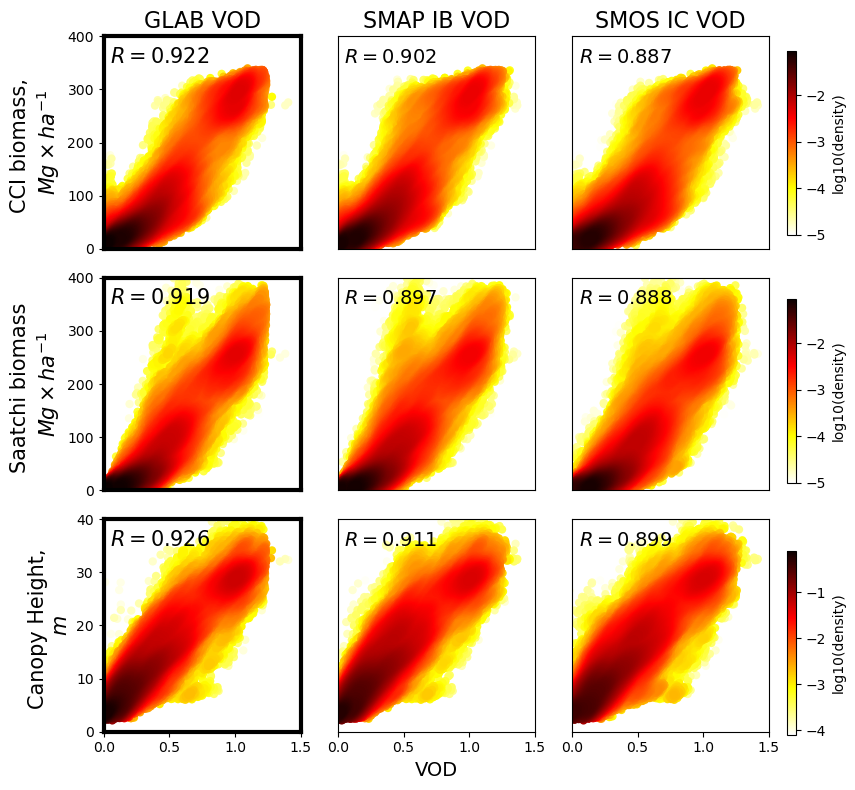

In [69]:
fig = plt.figure(figsize=(8, 8))
vmin = -5
vmax = -1.05
vmin2= -4.1
vmax2= -0.1
vmin1= -2
vmax1= 1.5
ax = fig.add_subplot(3, 3, 1)
kk = ax.scatter(density['x_cci'], density['y_cci'], c=density['log_z_cci'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('GLAB-VOD') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
plt.ylabel('CCI biomass, \n' +  r'$Mg \times ha^{-1}$', fontsize=15)
plt.xlim([0, 1.5])
plt.ylim([0,400])
plt.xticks([])
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_ticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.text(0.05, 350, r'$R = $' + str(R_cci_glab), fontsize=15, fontweight="bold")
plt.title( 'GLAB VOD',  fontsize=16)

ax = fig.add_subplot(3, 3, 2)
kk = ax.scatter(density_raw['x_cci'], density_raw['y_cci'], c=density_raw['log_z_cci'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('VOD IB') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
plt.xlim([0, 1.5])
plt.ylim([0,400])
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_ticks([])
plt.xticks([])
plt.yticks([])



plt.text(0.05, 350, r'$R = $' + str(R_cci_ib), fontsize=14)
plt.title( 'SMAP IB VOD', fontsize=16)


ax = fig.add_subplot(3, 3, 3)
kk = ax.scatter(density_ic['x_cci'], density_ic['y_cci'], c=density_ic['log_z_cci'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('VOD IC') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
plt.xlim([0, 1.5])
plt.ylim([0,400])
plt.text(0.05, 350, r'$R = 0.887$', fontsize=14)
plt.title( 'SMOS IC VOD', fontsize=16)
plt.xticks([])
plt.yticks([])
cb_ax = fig.add_axes([0.99,.70,.011,.23])
cb = plt.colorbar(kk, cax = cb_ax, shrink=0.95)
#cb.set_ticks([])
cb.set_label('log10(density)')






ax = fig.add_subplot(3, 3, 4)
kk = ax.scatter(density['x_saa'], density['y_saa'], c=density['log_z_saa'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('GLAB-VOD') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
plt.xticks([])
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_label('log10(density)')
#cb.set_ticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.text(0.05, 350, r'$R = $' + str(R_saatchi_glab), fontsize=15, fontweight="bold")
plt.ylabel( 'Saatchi biomass \n' + r'$Mg \times ha^{-1}$', fontsize=15)
plt.xlim([0, 1.5])
plt.ylim([0,400])



ax = fig.add_subplot(3, 3, 5)
kk = ax.scatter(density_raw['x_saa'], density_raw['y_saa'], c=density_raw['log_z_saa'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('VOD IB') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_label('log10(density)')
#cb.set_ticks([])

plt.text(0.05, 350, r'$R = $' + str(R_saatchi_ib), fontsize=14)
#plt.title( 'Saatchi biomass')
plt.xlim([0, 1.5])
plt.ylim([0,400])
plt.xticks([])
plt.yticks([])


ax = fig.add_subplot(3, 3, 6)
kk = ax.scatter(density_ic['x_saa'], density_ic['y_saa'], c=density_ic['log_z_saa'],  edgecolor='none', cmap='hot_r', vmin=vmin, vmax=vmax)
#plt.xlabel('VOD IC') #, fontsize=14)
#plt.ylabel(r'AGB, $Mg \times ha^{-1}$')
plt.xticks([])
plt.yticks([])
plt.text(0.05, 350, r'$R = 0.888$', fontsize=14)
#plt.title( 'Saatchi biomass')
plt.xlim([0, 1.5])
plt.ylim([0,400])
cb_ax = fig.add_axes([.99,.39,.011,.23])
cb = plt.colorbar(kk, cax = cb_ax, shrink=0.95)
cb.set_label('log10(density)')
#cb.set_ticks([])




ax = fig.add_subplot(3, 3, 7)
kk = ax.scatter(density['x_ca'], density['y_ca'], c=density['log_z_ca'],  edgecolor='none', cmap='hot_r', vmin=vmin2, vmax=vmax2)
#plt.xlabel('GLAB-VOD', fontsize=16)
plt.ylabel('Canopy Height, \n$m$', fontsize=15)
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_ticks([])

plt.text(0.05, 35, r'$R = $' + str(R_canopy_glab), fontsize=15, fontweight="bold")
#plt.title( 'Canopy height')
plt.xlim([0, 1.5])
plt.ylim([0, 40])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

ax = fig.add_subplot(3, 3, 8)
kk = ax.scatter(density_raw['x_ca'], density_raw['y_ca'], c=density_raw['log_z_ca'],  edgecolor='none', cmap='hot_r', vmin=vmin2, vmax=vmax2)
#plt.xlabel('VOD IB', fontsize=16) #, fontsize=14)
#plt.ylabel('Canopy Height, $m$')
#cb = plt.colorbar(kk, shrink=0.95)
#cb.set_ticks([])

plt.text(0.05, 35, r'$R = $' + str(R_canopy_ib), fontsize=14)
#plt.title( 'Canopy height')
plt.xlim([0, 1.5])
plt.ylim([0, 40])
plt.yticks([])
plt.xlabel('VOD', fontsize = 14)



ax = fig.add_subplot(3, 3, 9)
kk = ax.scatter(density_ic['x_ca'], density_ic['y_ca'], c=density_ic['log_z_ca'],  edgecolor='none', cmap='hot_r', vmin=vmin2, vmax=vmax2)
#plt.xlabel('VOD IC', fontsize=16) #, fontsize=14)
plt.text(0.05, 35, r'$R = 0.899$', fontsize=14)
#plt.title( 'Canopy height')
plt.xlim([0, 1.5])
plt.ylim([0, 40])
plt.yticks([])
#plt.ylabel('Canopy Height, $m$')
cb_ax = fig.add_axes([.99,.075,.011,.23])
cb = plt.colorbar(kk, cax = cb_ax, shrink=0.95)
#cb.set_ticks([])
cb.set_label('log10(density)')






fig.tight_layout()

plt.savefig('biomass_comapre3by3.png', dpi = 500, bbox_inches='tight')



plt.show()

In [124]:
csif_kde = pd.read_pickle(path_to_files + 'vod_csif_kde2019.pkl')
csif_kde.head()

x_glab    y_glab    z_glab      x_ic      y_ic      z_ic      x_ib  \
0  1.280413  0.293289  0.003104  1.325680  0.293289  0.002765  1.340172   
1  0.244191  0.444082  0.003334  0.902562  0.541401  0.003591  0.252678   
2  1.104185  0.216804  0.003637  1.088252  0.176301  0.003940  0.066151   
3  1.117622  0.189548  0.004450 -0.000339  0.288710  0.004063  1.119526   
4  1.070676  0.176301  0.004503  0.264924  0.444082  0.004072  1.072334   

       y_ib      z_ib  
0  0.293289  0.003361  
1  0.444082  0.003624  
2  0.312680  0.004161  
3  0.189548  0.004665  
4  0.176301  0.004725

In [126]:
csif_kde['log_z_glab'] = np.log10(csif_kde['z_glab'])
csif_kde['log_z_ic'] = np.log10(csif_kde['z_ic'])
csif_kde['log_z_ib'] = np.log10(csif_kde['z_ib'])

In [101]:
sif_vod = pd.read_pickle(path_to_files +'sif_vod_pft_full_2019.pkl')
sif_vod.head()

lat        lon  classes     time_x  clear_daily_SIF  str_mean  \
0 -51.904213 -71.714699      9.0 2019-12-31         0.188825  0.254805   
1 -51.904213 -71.455330      9.0 2019-12-31         0.144157  0.184017   
2 -51.904213 -71.195969      9.0 2019-12-31         0.079037  0.142888   
3 -51.904213 -70.936600      9.0 2019-12-31         0.072462  0.124212   
4 -51.904213 -70.677231      9.0 2019-12-31         0.070041  0.118362   

      time_y    vod_ic       time    vod_ib  
0 2019-12-31  0.261553 2019-12-31  0.253118  
1 2019-12-31  0.197331 2019-12-31  0.184790  
2 2019-12-31  0.154918 2019-12-31  0.145774  
3 2019-12-31  0.134182 2019-12-31  0.127717  
4 2019-12-31  0.122423 2019-12-31  0.121579

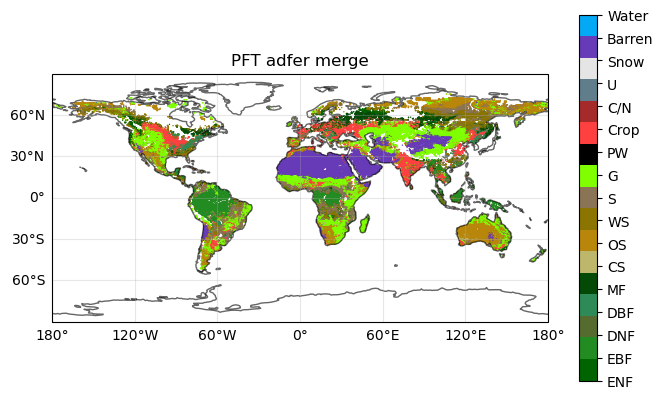

In [146]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
#ax.set_extent([-85, -65, 17.5, 23], crs=ccrs.PlateCarree())
ax.coastlines(alpha = 0.6)
gls = ax.gridlines(draw_labels=True, alpha = 0.3)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels vmin=0, vmax=1  marker = '.', s=10, vmin=-0.01, vmax=0.01,
    

sm = plt.scatter(x = sif_vod['lon'], y = sif_vod['lat'], c= sif_vod['classes'], s=1,  cmap=cmap_pft, edgecolors=None, linewidth=0)
cbar = fig.colorbar(sm, ax=ax, shrink=0.95)
cbar.set_ticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
cbar.set_ticklabels(['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CS', 'OS', 'WS', 'S', 'G', 'PW', 'Crop', 'C/N', 'U', 'Snow', 'Barren', 'Water'])

plt.title('PFT adfer merge')



plt.show()

In [145]:
from matplotlib.colors import ListedColormap

# Define the colors for the colormap
colors = ['#006400', '#228B22', '#556B2F', '#2E8B57', '#054907',
          '#BDB76B', '#B8860B', '#8B7500', '#8B7355', '#7FFF00',
          '#000000', '#FF4040', '#A52A2A', '#607D8B', '#E5E5E5',
         '#673AB7', '#03A9F4'  ]

# Create the colormap
cmap_pft = ListedColormap(colors)

In [169]:
from matplotlib.gridspec import GridSpec

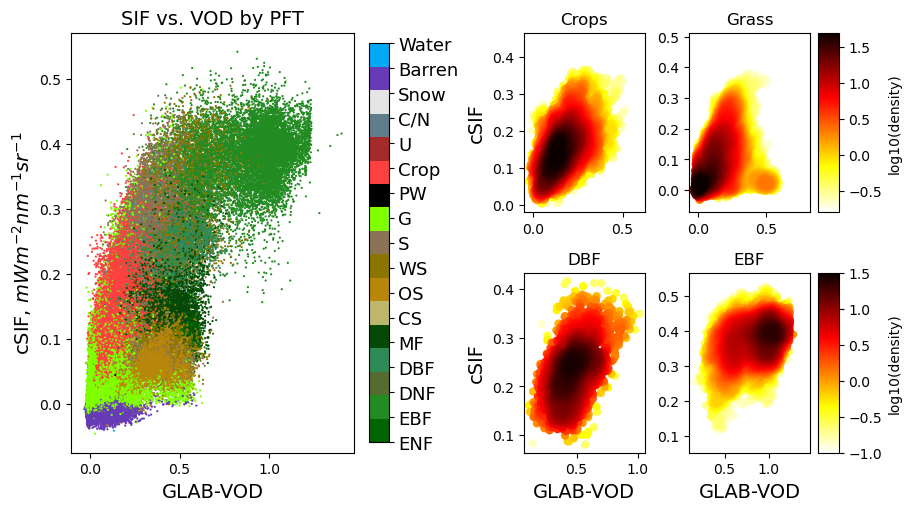

In [207]:

fig = plt.figure(figsize=(9, 5), layout="constrained")

gs = GridSpec(2, 4, figure=fig, height_ratios=[1,1], width_ratios=[1.4,0.6,0.6, 0.1])
ax1 = fig.add_subplot(gs[:, 0])
kk = ax1.scatter(sif_vod['str_mean'], sif_vod['clear_daily_SIF'], c=sif_vod['classes'],  edgecolor='none', s= 2.5,  cmap = cmap_pft)
plt.xlabel('GLAB-VOD', fontsize=14)
plt.ylabel('cSIF, $mW m^{-2} nm^{-1} sr^{-1}$', fontsize=14)
cbar = fig.colorbar(kk,  shrink=0.95)
cbar.set_ticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ])
cbar.set_ticklabels(['ENF', 'EBF', 'DNF', 'DBF', 'MF', 'CS', 'OS', 'WS', 'S', 'G', 'PW', 'Crop', 'U', 'C/N', 'Snow', 'Barren', 'Water'], fontsize=13)
#plt.legend(fontsize=14)
#plt.text(0, 0.45, r'$R = 0.81$')
plt.title( 'SIF vs. VOD by PFT', fontsize=14)

ax2 = fig.add_subplot(gs[0, 1])

kk = ax2.scatter(x, y, c=log_z_,  edgecolor='none', cmap='hot_r', vmin = -0.8, vmax = 1.7)
#plt.xlabel('GLAB-VOD', fontsize=14)
plt.ylabel('cSIF', fontsize=14)
plt.title( 'Crops')

ax3 = fig.add_subplot(gs[0, 2])

kk = ax3.scatter(x_g, y_g, c=log_z_g,  edgecolor='none', cmap='hot_r', vmin = -0.8, vmax = 1.7)
#plt.xlabel('GLAB-VOD', fontsize=14)
#plt.ylabel('cSIF', fontsize=14)
plt.title( 'Grass')

cb_ax = fig.add_subplot(gs[0, 3])

cb = plt.colorbar(kk, cax = cb_ax, shrink=0.95)
cb.set_label('log10(density)')

ax4 = fig.add_subplot(gs[1, 1])

kk = ax4.scatter(x_d, y_d, c=log_z_d,  edgecolor='none', cmap='hot_r', vmin = -1, vmax = 1.5)
plt.xlabel('GLAB-VOD', fontsize=14)
plt.ylabel('cSIF', fontsize=14)
plt.title( 'DBF')

ax5 = fig.add_subplot(gs[1, 2])

kk = ax5.scatter(x_e, y_e, c=log_z_e,  edgecolor='none', cmap='hot_r', vmin = -1, vmax = 1.5)
plt.xlabel('GLAB-VOD', fontsize=14)
#plt.ylabel('cSIF', fontsize=14)
plt.title( 'EBF')
cb_ax = fig.add_subplot(gs[1, 3])

cb = plt.colorbar(kk, cax = cb_ax, shrink=0.95)
cb.set_label('log10(density)')

plt.savefig('csif_vod_pft.png', dpi = 500, bbox_inches='tight')

plt.show()

In [160]:
def kde_short(df, classes, param1, param2):
    short = df[df['classes']==classes] #crops
    print(short.shape)
    print(short[param1].corr(short[param2]))
    x = short[param1].values
    y = short[param2].values
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x = x[idx]
    y = y[idx]
    z = z[idx]
    log_z_ = np.log10(z)
    return x, y, log_z_

In [161]:
x_g, y_g, log_z_g = kde_short(sif_vod, 9., 'str_mean', 'clear_daily_SIF')

(29887, 10)
0.4775179300325363


In [162]:
x_d, y_d, log_z_d = kde_short(sif_vod, 3., 'str_mean', 'clear_daily_SIF')

(2544, 10)
0.48461079500904963


In [163]:
x_e, y_e, log_z_e = kde_short(sif_vod, 1., 'str_mean', 'clear_daily_SIF')

(11440, 10)
0.35897971389207994
